## **Détection de Discours Suspect dans les Tweets : Évaluation et Développement de Modèles de Machine Learning**

### **Introduction**

L’émergence et la prolifération des réseaux sociaux ont engendré de nouvelles problématiques liées à la sécurité, à la modération et à la régulation des discours en ligne. En particulier, les plateformes comme Twitter voient se multiplier des contenus potentiellement suspects ou nuisibles, posant des risques de désinformation, de harcèlement, et d’incitation à la haine. Dans ce contexte, la détection automatisée de discours suspect dans les tweets devient essentielle pour prévenir et modérer efficacement les échanges en ligne.

Ce projet vise à appliquer des méthodes avancées de traitement du langage naturel (NLP) et de machine learning pour détecter automatiquement les tweets suspects. Notre objectif est de concevoir un modèle de classification robuste et fiable, capable de distinguer le contenu suspect du contenu inoffensif, et de tester ce modèle dans un environnement de production simulé.

### **Objectifs de l’Étude**

1. **Comprendre les fondements et les défis** de l’application du machine learning à la détection de discours suspect dans un contexte textuel, en tenant compte de la complexité des données non structurées issues de tweets.
2. **Développer et évaluer différents modèles de classification** capables d’identifier les tweets suspects, avec une attention particulière portée à la gestion du déséquilibre des classes, étant donné que la proportion de discours suspect peut être relativement faible par rapport au volume global de tweets.
3. **Déployer un modèle optimisé** pour une utilisation pratique, en proposant des pistes d’application et de maintenance pour un usage continu dans un cadre de modération.

### Chargement et Exploration des Données

Nous allons charger le dataset et afficher un aperçu des données.


In [3]:
# Imports des modules de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score,
    make_scorer
)
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from scikeras.wrappers import KerasClassifier

from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from joblib import dump, load


In [9]:
# Charger le dataset
df = pd.read_csv('../data/tweets_suspect.csv')

# Aperçu des premières lignes du dataset
df.head()


,message,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
1,is upset that he can't update his Facebook by ...,1
2,@Kenichan I dived many times for the ball. Man...,1
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",1


In [3]:
# Informations sur le dataset
df.info()

# Statistiques descriptives pour les labels
df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  60000 non-null  object
 1   label    60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB


label
1    53855
0     6145
Name: count, dtype: int64

In [4]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  being sick really sucks!  Especailly since thi...    2
1       53855  53574                            @chromachris  Clean Me!    7

In [5]:
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


### Analyse Exploratoire

1. **Distribution des Classes** : Visualisation de la distribution des tweets suspects (`label = 1`) et non suspects (`label = 0`).



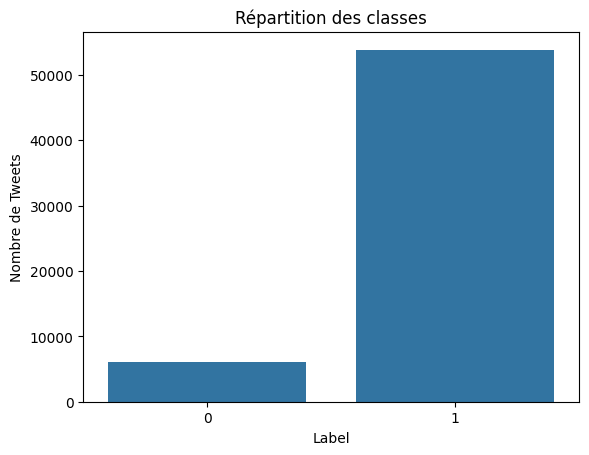

In [6]:
# Visualisualisation la répartition des classes
sns.countplot(x='label', data=df)
plt.title('Répartition des classes')
plt.xlabel('Label')
plt.ylabel('Nombre de Tweets')
plt.show()


2. **Longueur des Tweets** : Examiner la longueur des tweets pour comprendre la variabilité du texte.




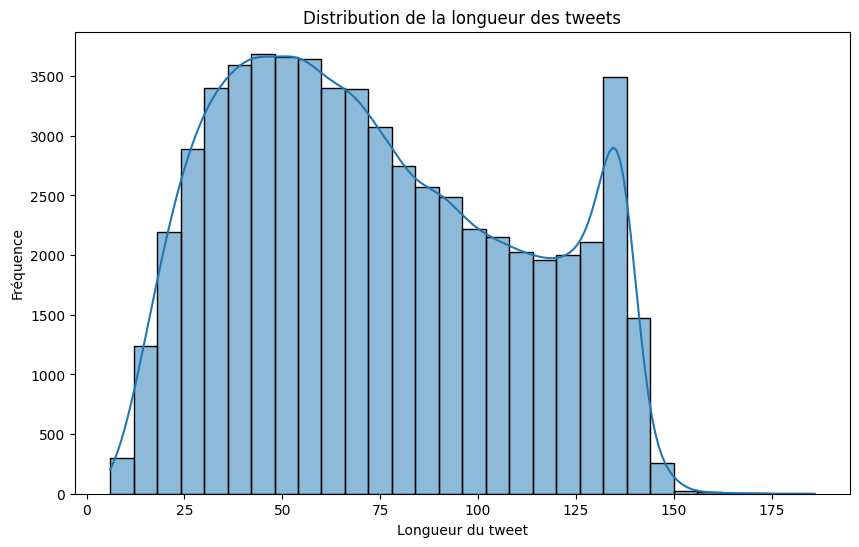

In [7]:
df['tweet_length'] = df['message'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribution de la longueur des tweets")
plt.xlabel("Longueur du tweet")
plt.ylabel("Fréquence")
plt.show()

C:\Users\Abdoul\AppData\Local\Temp\ipykernel_3968\2941830790.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_Class = pd.value_counts(df.label, sort = True)


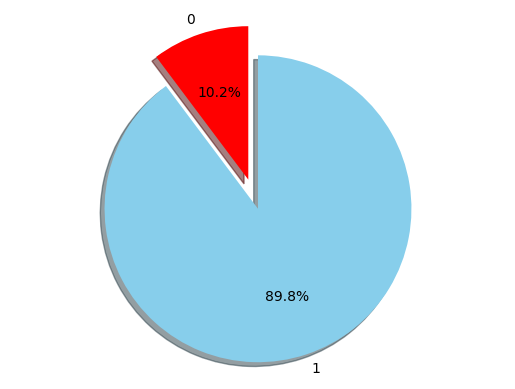

In [8]:
count_Class = pd.value_counts(df.label, sort = True)

# Data to Plot
labels = '0', '1'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)

# Plot
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

### Prétraitement des Données

1. **Nettoyage des Tweets** : Nous allons appliquer plusieurs étapes pour nettoyer les messages en supprimant les mentions, les liens, et les caractères spéciaux. 

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement
def preprocess_text(sen):
    # Suppression des URLs
    sentence = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', ' ', sen)
    # Suppression des caractères spéciaux, ponctuations et chiffres
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Suppression des caractères uniques et multiple espaces
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Traitement des contractions courantes
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    
    # Conversion en minuscules et suppression des stop words
    sentence = ' '.join(word.lower() for word in sentence.split() if word not in stop_words)
    
    # Lemmatisation (ou stemming)
    sentence = ' '.join(lemmatizer.lemmatize(word) for word in sentence.split())
    
    return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdoul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdoul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Application du nettoyage au dataset
df['cleaned_text'] = df['message'].apply(preprocess_text)

# Exemple avant/après nettoyage
print("\nExemple avant nettoyage :")
print(df['message'].iloc[0])
print("\nExemple après nettoyage :")
print(df['cleaned_text'].iloc[0])


Exemple avant nettoyage :
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

Exemple après nettoyage :
switchfoot bummer you shoulda got david carr third day d


In [11]:
# Vectorisation
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['cleaned_text'])

# Transformation TF-IDF
transformer = TfidfTransformer()
counts = transformer.fit_transform(counts)

In [12]:
# Affichage des dimensions de la matrice TF-IDF
print("\nDimensions de la matrice TF-IDF :")
print(counts.shape)


Dimensions de la matrice TF-IDF :
(60000, 52023)


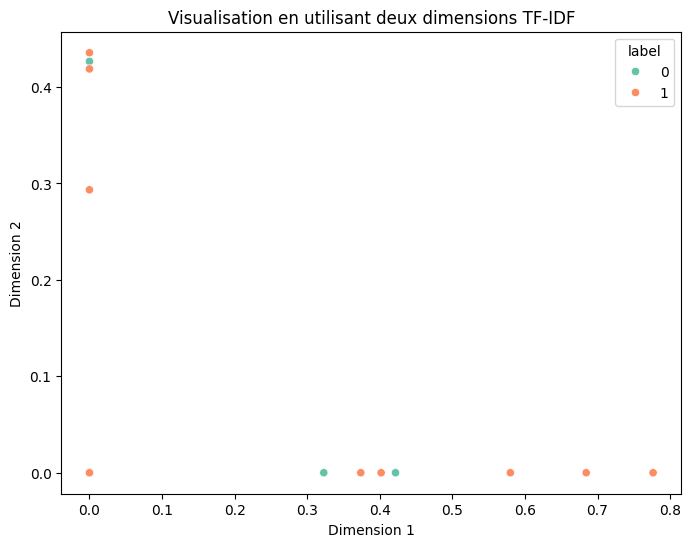

In [13]:
#  deux dimensions spécifiques (colonnes du TF-IDF)
dim1 = 0  # Exemple : la première dimension
dim2 = 1  # Exemple : la deuxième dimension

plt.figure(figsize=(8, 6))
sns.scatterplot(x=counts[:, dim1].toarray().flatten(), 
                y=counts[:, dim2].toarray().flatten(), 
                hue=df['label'], palette='Set2')
plt.title("Visualisation en utilisant deux dimensions TF-IDF")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


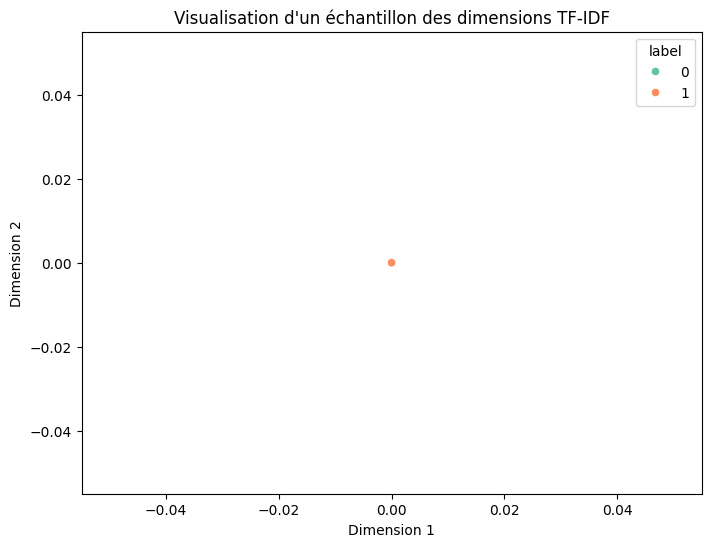

In [14]:
sample_data = counts[:100, :2].toarray()  # Par exemple, les 100 premiers textes et les 2 premières dimensions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sample_data[:, 0], y=sample_data[:, 1], hue=df['label'][:100], palette='Set2')
plt.title("Visualisation d'un échantillon des dimensions TF-IDF")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [17]:
# Visualisation des données après réduction (si classes présentes)
if 'classe' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tfidf_pca[:, 0], y=tfidf_pca[:, 1], hue=df['Label'], palette='Set2')
    plt.title("Visualisation des données après PCA")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.show()

In [18]:
# Sauvegarde du dataset nettoyé
df.to_csv("../data/dataset_nettoye.csv", index=False)

print("\nPrétraitement terminé. Le dataset nettoyé a été sauvegardé sous 'dataset_nettoye.csv'.")


Prétraitement terminé. Le dataset nettoyé a été sauvegardé sous 'dataset_nettoye.csv'.


In [19]:
# Séparation des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

In [20]:
# Vérification de la répartition des classes
print("\nRépartition des classes avant équilibrage :")
print(y_train.value_counts())


Répartition des classes avant équilibrage :
label
1    37724
0     4276
Name: count, dtype: int64


In [21]:
# Application de SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Vérification de la nouvelle répartition
print("\nRépartition des classes après sur-échantillonnage :")
print(y_train_balanced.value_counts())



Répartition des classes après sur-échantillonnage :
label
1    37724
0    37724
Name: count, dtype: int64


In [79]:
# Modèle 1 : Régression logistique
print("\n### Modèle 1 : Logistic Regression ###")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_balanced, y_train_balanced)
y_pred_log_reg = log_reg.predict(X_test)
print(classification_report(y_test, y_pred_log_reg))


### Modèle 1 : Logistic Regression ###
              precision    recall  f1-score   support

           0       0.47      0.78      0.58      1869
           1       0.97      0.90      0.93     16131

    accuracy                           0.89     18000
   macro avg       0.72      0.84      0.76     18000
weighted avg       0.92      0.89      0.90     18000



In [80]:
# Modèle 2 : Random Forest
print("\n### Modèle 2 : Random Forest ###")
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_balanced, y_train_balanced)
y_pred_rf = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_rf))


### Modèle 2 : Random Forest ###
              precision    recall  f1-score   support

           0       0.47      0.56      0.51      1869
           1       0.95      0.93      0.94     16131

    accuracy                           0.89     18000
   macro avg       0.71      0.74      0.72     18000
weighted avg       0.90      0.89      0.89     18000



In [23]:
# Modèle 3 : SVM (Support Vector Machine)
print("\n### Modèle 3 : SVM ###")
svm = SVC(random_state=42)
svm.fit(X_train_balanced, y_train_balanced)
y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


### Modèle 3 : SVM ###
              precision    recall  f1-score   support

           0       0.84      0.52      0.64      1869
           1       0.95      0.99      0.97     16131

    accuracy                           0.94     18000
   macro avg       0.89      0.75      0.80     18000
weighted avg       0.94      0.94      0.93     18000



In [82]:
# Matrices de confusion pour chaque modèle
print("\n### Matrice de confusion : Logistic Regression ###")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\n### Matrice de confusion : Random Forest ###")
print(confusion_matrix(y_test, y_pred_rf))
print("\n### Matrice de confusion : SVM ###")
print(confusion_matrix(y_test, y_pred_svm))



### Matrice de confusion : Logistic Regression ###
[[ 1450   419]
 [ 1650 14481]]

### Matrice de confusion : Random Forest ###
[[ 1048   821]
 [ 1189 14942]]

### Matrice de confusion : SVM ###
[[  972   897]
 [  192 15939]]



### Comparaison globale des performances ###

### Performances pour Logistic Regression ###
Accuracy       : 0.8851
Precision      : 0.9195
Recall         : 0.8851
F1-Score       : 0.8970

### Performances pour Random Forest ###
Accuracy       : 0.8883
Precision      : 0.8981
Recall         : 0.8883
F1-Score       : 0.8927

### Performances pour SVM ###
Accuracy       : 0.9395
Precision      : 0.9351
Recall         : 0.9395
F1-Score       : 0.9331

### Résumé des métriques comparatives ###
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.885056   0.919533  0.885056  0.897014
1        Random Forest  0.888333   0.898135  0.888333  0.892693
2                  SVM  0.939500   0.935126  0.939500  0.933115


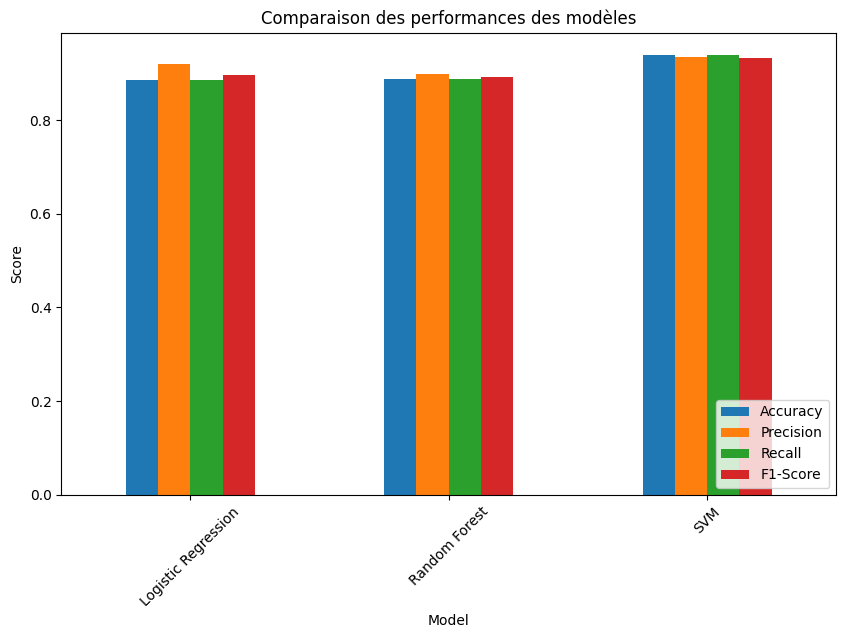

In [83]:

# Fonction pour afficher les métriques globales
def display_global_metrics(model_name, y_true, y_pred):
    print(f"\n### Performances pour {model_name} ###")
    print(f"Accuracy       : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision      : {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall         : {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score       : {f1_score(y_true, y_pred, average='weighted'):.4f}")

# Comparaison des modèles
print("\n### Comparaison globale des performances ###")
display_global_metrics("Logistic Regression", y_test, y_pred_log_reg)
display_global_metrics("Random Forest", y_test, y_pred_rf)
display_global_metrics("SVM", y_test, y_pred_svm)

# Résumé visuel [Optionnel]
# Création d'un DataFrame pour un affichage comparatif
metrics_comparison = {
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log_reg, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    "Recall": [
        recall_score(y_test, y_pred_log_reg, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log_reg, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
}

# Affichage dans un tableau
metrics_df = pd.DataFrame(metrics_comparison)
print("\n### Résumé des métriques comparatives ###")
print(metrics_df)

# Visualisation des performances [Optionnel]
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Comparaison des performances des modèles")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


In [86]:
# Validation croisée avec scikit-learn

# Fonction pour effectuer la validation croisée sur chaque modèle
def cross_validation(model, X_train, y_train, cv=5):
    # Utilisation de la validation croisée
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Scores de validation croisée pour {model.__class__.__name__}: {scores}")
    print(f"Moyenne des scores : {scores.mean():.4f}")
    print(f"Écart-type des scores : {scores.std():.4f}")
    return scores.mean()

#  la validation croisée sur chaque modèle
print("\n### Validation croisée : Logistic Regression ###")
cross_val_score_log_reg = cross_validation(log_reg, X_train_balanced, y_train_balanced)

print("\n### Validation croisée : Random Forest ###")
cross_val_score_rf = cross_validation(random_forest, X_train_balanced, y_train_balanced)

print("\n### Validation croisée : SVM ###")
cross_val_score_svm = cross_validation(svm, X_train_balanced, y_train_balanced)



### Validation croisée : Logistic Regression ###
Scores de validation croisée pour LogisticRegression: [0.88555335 0.92637508 0.92153744 0.92676784 0.92756313]
Moyenne des scores : 0.9176
Écart-type des scores : 0.0161

### Validation croisée : Random Forest ###
Scores de validation croisée pour RandomForestClassifier: [0.92213386 0.96030484 0.95990722 0.95970575 0.96169395]
Moyenne des scores : 0.9527
Écart-type des scores : 0.0153

### Validation croisée : SVM ###
Scores de validation croisée pour SVC: [0.93359841 0.99416832 0.9944334  0.99436676 0.99549341]
Moyenne des scores : 0.9824
Écart-type des scores : 0.0244


In [ ]:
# Validation croisée avec TensorFlow/Keras (si vous voulez l'ajouter)

# Fonction de création du modèle LSTM pour KerasClassifier
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  le modèle LSTM en un modèle compatible avec scikit-learn
model_lstm = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

# Validation croisée avec LSTM
print("\n### Validation croisée : LSTM ###")
cross_val_score_lstm = cross_val_score(model_lstm, X_train_balanced, y_train_balanced, cv=5)
print(f"Scores de validation croisée : {cross_val_score_lstm}")
print(f"Moyenne des scores : {cross_val_score_lstm.mean():.4f}")


In [115]:
#Validation croisée avec PyTorch
# Exemple de modèle PyTorch (à définir en fonction de vos besoins)
class SimpleModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [113]:
# Affichage du rapport de classification pour le modèle Logistic Regression
print("\n### Rapport de classification : Logistic Regression ###")
print(classification_report(y_test, y_pred_log_reg))

# Pour les autres modèles :
print("\n### Rapport de classification : Random Forest ###")
print(classification_report(y_test, y_pred_rf))

print("\n### Rapport de classification : SVM ###")
print(classification_report(y_test, y_pred_svm))



### Rapport de classification : Logistic Regression ###
              precision    recall  f1-score   support

           0       0.47      0.78      0.58      1869
           1       0.97      0.90      0.93     16131

    accuracy                           0.89     18000
   macro avg       0.72      0.84      0.76     18000
weighted avg       0.92      0.89      0.90     18000


### Rapport de classification : Random Forest ###
              precision    recall  f1-score   support

           0       0.47      0.56      0.51      1869
           1       0.95      0.93      0.94     16131

    accuracy                           0.89     18000
   macro avg       0.71      0.74      0.72     18000
weighted avg       0.90      0.89      0.89     18000


### Rapport de classification : SVM ###
              precision    recall  f1-score   support

           0       0.84      0.52      0.64      1869
           1       0.95      0.99      0.97     16131

    accuracy                     


### Matrice de confusion : Logistic Regression ###


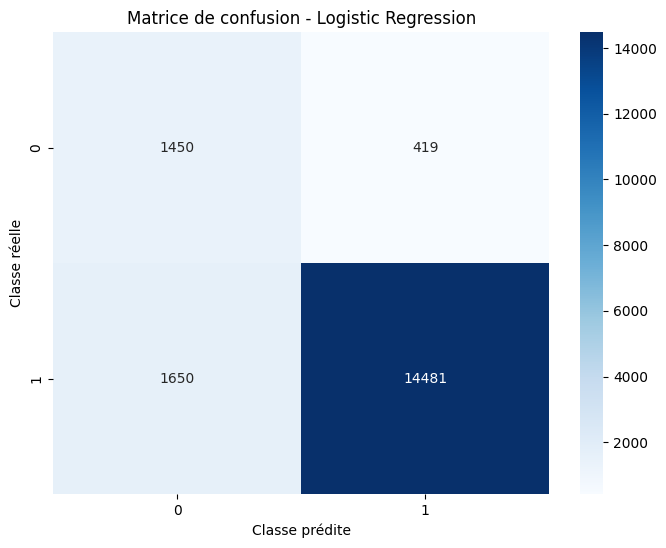


### Matrice de confusion : Random Forest ###


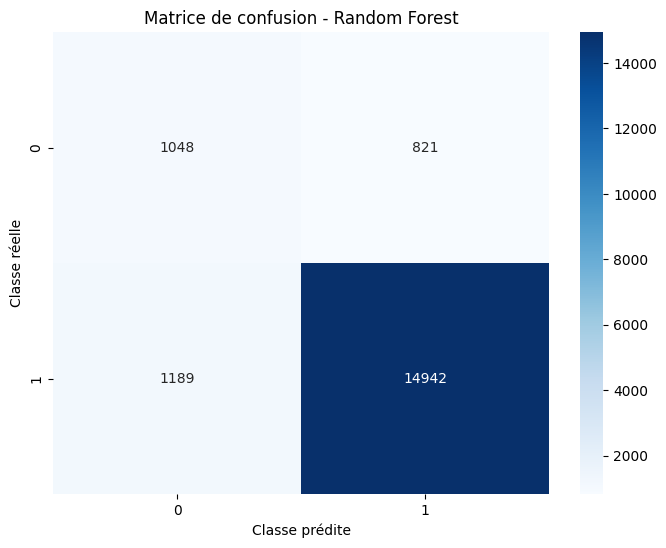


### Matrice de confusion : SVM ###


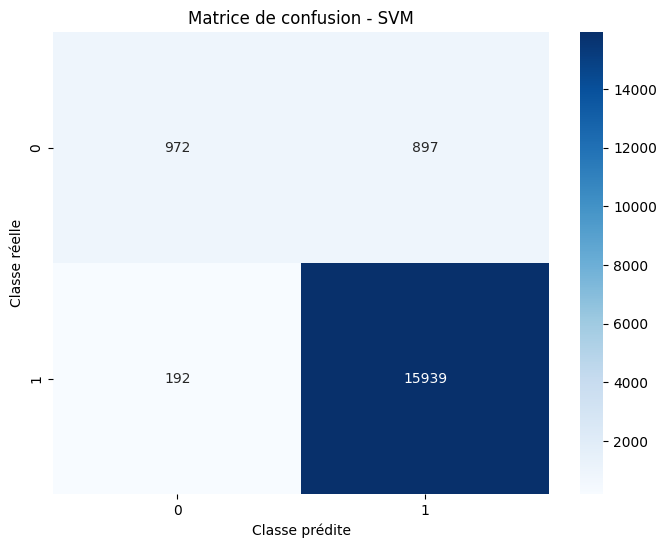

In [118]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.show()

# Matrices de confusion pour chaque modèle
print("\n### Matrice de confusion : Logistic Regression ###")
plot_confusion_matrix(y_test, y_pred_log_reg, "Logistic Regression")

print("\n### Matrice de confusion : Random Forest ###")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

print("\n### Matrice de confusion : SVM ###")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")



### Courbe ROC : Logistic Regression ###


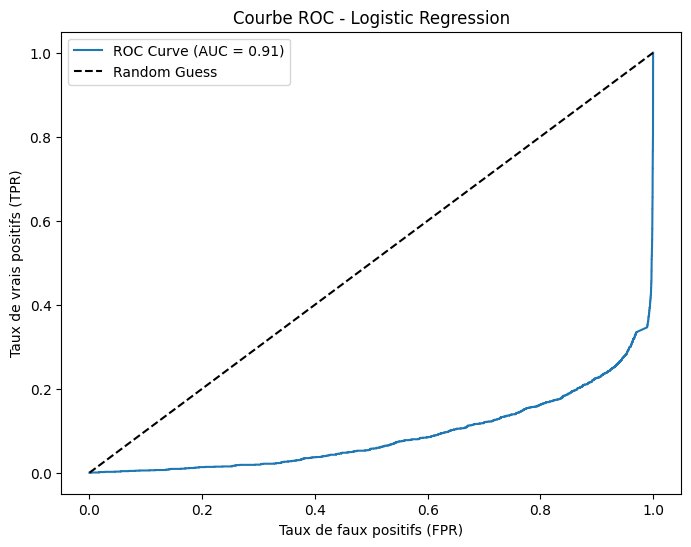


### Courbe ROC : Random Forest ###


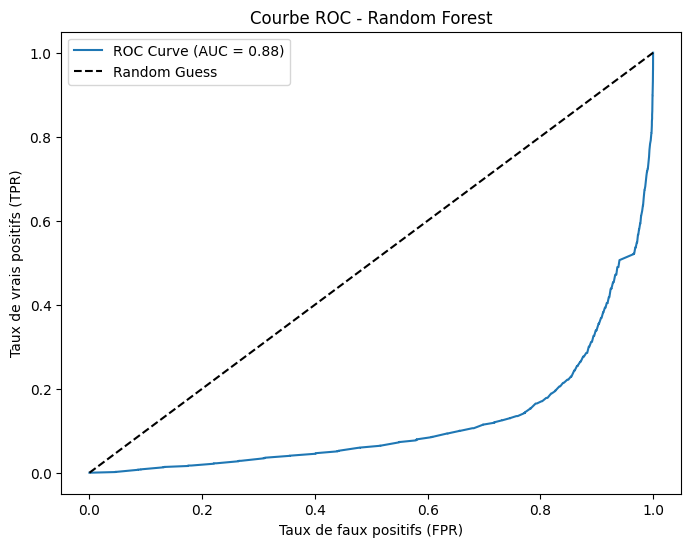


### Courbe ROC : SVM ###


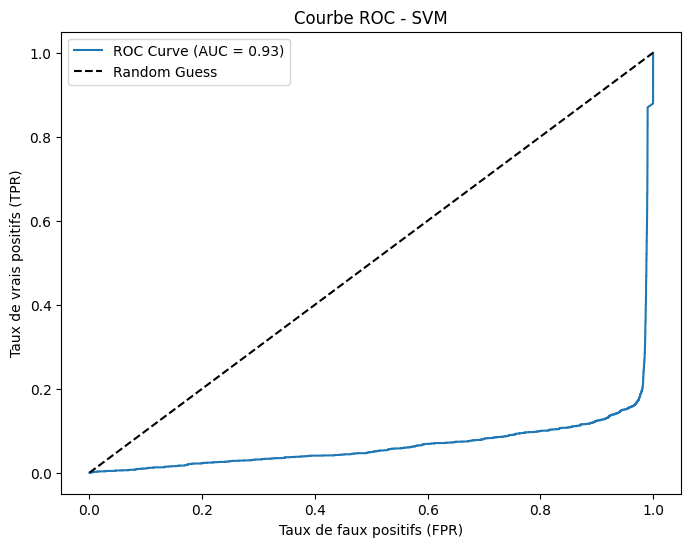

In [119]:
# Fonction pour tracer la courbe ROC
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs, pos_label=y_true.unique()[1])  # Ajustez pos_label si nécessaire
    auc = roc_auc_score(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"Courbe ROC - {model_name}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.legend(loc="best")
    plt.show()

# Logistic Regression
y_probs_log_reg = log_reg.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive
print("\n### Courbe ROC : Logistic Regression ###")
plot_roc_curve(y_test, y_probs_log_reg, "Logistic Regression")

# Random Forest
y_probs_rf = random_forest.predict_proba(X_test)[:, 1]
print("\n### Courbe ROC : Random Forest ###")
plot_roc_curve(y_test, y_probs_rf, "Random Forest")

# SVM
# Pour SVM avec kernel 'linear', utiliser `decision_function`; sinon, `predict_proba` si disponible.
y_probs_svm = svm.decision_function(X_test)  # Changer si 'predict_proba' est utilisé
print("\n### Courbe ROC : SVM ###")
plot_roc_curve(y_test, y_probs_svm, "SVM")


In [34]:
#  les hyperparamètres à tester
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Régularisation inverse
    'penalty': ['l1', 'l2', 'elasticnet'],  # Types de régularisation
    'solver': ['liblinear', 'saga']  # Solveurs compatibles
}

log_reg_2 = LogisticRegression(max_iter=1000, random_state=42)

grid_search_log = GridSearchCV(estimator=log_reg_2, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_log.fit(X_train_balanced, y_train_balanced)

# Meilleurs hyperparamètres
print("\nMeilleurs paramètres pour Logistic Regression :", grid_search_log.best_params_)

best_log_reg = grid_search_log.best_estimator_
y_pred_best_log_reg = best_log_reg.predict(X_test)
print(classification_report(y_test, y_pred_best_log_reg))


C:\Users\Abdoul\myenv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Abdoul\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abdoul\myenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Abdoul\myenv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:


Meilleurs paramètres pour Logistic Regression : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.59      0.85      0.70      1869
           1       0.98      0.93      0.96     16131

    accuracy                           0.92     18000
   macro avg       0.79      0.89      0.83     18000
weighted avg       0.94      0.92      0.93     18000



In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

random_forest_2 = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=random_forest_2 , param_grid=param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

# Meilleurs hyperparamètres
print("\nMeilleurs paramètres pour Random Forest :", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

#  le modèle SVM
svm_2 = SVC(random_state=42)

grid_search_svm = GridSearchCV(estimator=svm_2, param_grid=param_grid_svm, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_svm.fit(X_train_balanced, y_train_balanced)

print("\nMeilleurs paramètres pour SVM :", grid_search_svm.best_params_)

best_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)
print(classification_report(y_test, y_pred_best_svm))


In [31]:
# Enregistrement avec joblib
dump(svm, "../models/svm_model.joblib")
dump(count_vect, "../models/tfidf_vectorizer.joblib")
print("Modèle et vectoriseur enregistrés avec succès.")

Modèle et vectoriseur enregistrés avec succès.


In [32]:
model = load("../models/svm_model.joblib")
vectorizer = load("../models/tfidf_vectorizer.joblib")

# tweets pour le test
test_tweets = ["Ceci est suspect", "Ceci semble normal"]

#  tweets en données vectorisées
X_input = vectorizer.transform(test_tweets)

#  prédictions
predictions = model.predict(X_input)

#  résultats
for tweet, pred in zip(test_tweets, predictions):
    print(f"Tweet: '{tweet}' => Résultat: {'Suspect' if pred == 0 else 'Non suspect'}")


Tweet: 'Ceci est suspect' => Résultat: Non suspect
Tweet: 'Ceci semble normal' => Résultat: Non suspect
